# **avec la colonne embedding**

In [ ]:
from camel_tools.disambig.bert import BERTUnfactoredDisambiguator
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch.utils.data import DataLoader, Dataset

# Détecter si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger le modèle de désambiguïsation CAMeL
#disambiguator = BERTUnfactoredDisambiguator.pretrained()

# Charger le modèle BERT pour obtenir les embeddings et le déplacer sur le GPU si disponible
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

MAX_LEN = 512

class SentencesDataset(Dataset):
    def __init__(self, sentences, tokenizer, max_len):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        inputs = self.tokenizer(sentence, return_tensors='pt', truncation=True, max_length=self.max_len, padding='max_length')
        return inputs

def get_sentence_embeddings(sentences):
    dataset = SentencesDataset(sentences, tokenizer, MAX_LEN)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=False)  # Adjust batch_size as needed

    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: value.squeeze(1).to(device) for key, value in batch.items()}
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.extend(batch_embeddings)

            # Débogage : vérifier le type et la forme des embeddings
            print(f"Type de batch_embeddings: {type(batch_embeddings)}")
            print(f"Shape de batch_embeddings: {batch_embeddings.shape}")
            if len(embeddings) > 0:
                print(f"Type du premier embedding: {type(embeddings[0])}")
                print(f"Shape du premier embedding: {embeddings[0].shape}")

    return embeddings

def preprocess_embeddings(df):
    sentences = df['Sentence'].tolist()
    embeddings = get_sentence_embeddings(sentences)
    # Convertir chaque numpy array en liste
    df['embedding'] = [embedding.tolist() for embedding in embeddings]
    return df
###
def find_best_match(word, sentence, df):
    # Calculer l'embedding de la phrase de l'entrée
    input_embedding = np.array(get_sentence_embeddings([sentence])[0])
    input_embedding = input_embedding.reshape(1, -1)  # Redimensionner pour la similarité

    # Convertir les listes d'embeddings stockés en numpy arrays
    df['embedding'] = df['embedding'].apply(lambda x: np.array(x))

    # Calculer la similarité cosinus
    df['similarity'] = df['embedding'].apply(lambda x: cosine_similarity(input_embedding, x.reshape(1, -1)).flatten())
    best_match = df.loc[df['similarity'].idxmax()]
    return best_match['Meaning']


# Exemple de phrase contenant un mot ambigu
word = 'يمين'
sentence = 'القدس المحتلة- تظهر نتائج فرز نحو 95% من الأصوات في انتخابات الكنيست الإسرائيلي -التي أجريت أمس الثلاثاء- أن الخارطة الحزبية الإسرائيلية تتجه إلى أقصى اليمين، وأن زعيم حزب الليكود بنيامين نتنياهو -الذي يرأس معسكر اليمين المتطرف- عزز من قوته البرلمانية، الأمر الذي يمنحه تفويضا لتشكيل الحكومة المقبلة.'

# Charger le dataset
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/bert/WSD_Arabic_Dataset.xlsx')

# Pré-calculer les embeddings du dataset
df = preprocess_embeddings(df)

# Trouver le sens du mot ambigu
meaning = find_best_match(word, sentence, df)
print(f"Le sens du mot '{word}' dans le contexte donné est : {meaning}")


In [ ]:
# Assurer que les embeddings sont sous forme de listes
df['embedding'] = df['embedding'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Sauvegarder le dataframe dans un fichier CSV
df.to_csv('/content/drive/MyDrive/Colab Notebooks/bert/embeddings.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity

# Charger le dataset avec les embeddings pré-calculés
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bert/embeddings.csv')

# Assurer que les embeddings sont convertis en numpy arrays
df['embedding'] = df['embedding'].apply(lambda x: np.array(eval(x)))

In [ ]:
df['embedding']

,embedding
0,"[0.2403232902288437, 0.044151194393634796, -0...."
1,"[0.12836140394210815, 0.17992427945137024, -0...."
2,"[0.2259705513715744, 0.13611991703510284, -0.1..."
3,"[0.2424807846546173, 0.08868288993835449, -0.0..."
4,"[0.31002315878868103, 0.16197732090950012, -0...."
...,...
3665,"[0.3133975863456726, 0.1443411260843277, -0.16..."
3666,"[0.20971818268299103, 0.23302441835403442, -0...."
3667,"[-0.00278541911393404, 0.2586679458618164, -0...."
3668,"[0.24326401948928833, 0.19319407641887665, -0...."


# **test**

In [ ]:
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import ast


# Charger le dataset avec les embeddings déjà calculés
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bert/embeddings.csv')
df['embedding'] = df['embedding'].apply(lambda x: np.array(eval(x)))

def split_data(df):
    # Diviser les données en ensembles d'entraînement et de test
    df_train = df.groupby('Meaning').apply(lambda x: x.sample(frac=0.8, random_state=1)).reset_index(drop=True)
    df_test = df.drop(df_train.index).reset_index(drop=True)
    return df_train, df_test

def find_best_match(sentence, df_train, tokenizer, model):
    # Calculer l'embedding de la phrase de l'entrée
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
    inputs = {key: value.squeeze(1) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    input_embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy().reshape(1, -1)

    # Convertir les embeddings stockés en numpy arrays
    #df_train['embedding'] = df_train['embedding'].apply(lambda x: np.array(ast.literal_eval(x)))

    # Calculer la similarité cosinus
    df_train['similarity'] = df_train['embedding'].apply(lambda x: cosine_similarity(input_embedding, x.reshape(1, -1)).flatten())
    best_match = df_train.loc[df_train['similarity'].idxmax()]
    return best_match['Meaning']

def evaluate_model(df_train, df_test, tokenizer, model):
    # Prévoir les sens des mots dans l'ensemble de test
   # df_test['predicted'] = df_test['Sentence'].apply(lambda x: find_best_match(x, df_train, tokenizer, model))
    # Calculer l'exactitude
    #accuracy = accuracy_score(df_test['Meaning'], df_test['predicted'])
     df_test['predicted'] = df_test['Sentence'].apply(lambda x: find_best_match(x, df_train, tokenizer, model))

    # Calculer l'exactitude
     accuracy = accuracy_score(df_test['Meaning'], df_test['predicted'])

    # Calculer la précision (par sens des mots, donc average='macro' ou 'weighted' si les classes sont déséquilibrées)
     precision = precision_score(df_test['Meaning'], df_test['predicted'], average='macro')

    # Calculer le F1-score (en moyenne macro pour prendre en compte toutes les classes)
     f1 = f1_score(df_test['Meaning'], df_test['predicted'], average='macro')

     return accuracy, precision, f1
   # return accuracy

# Charger le tokenizer et le modèle BERT
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to('cuda' if torch.cuda.is_available() else 'cpu')

# Séparer les données en ensembles d'entraînement et de test
df_train, df_test = split_data(df)

# Évaluer le modèle
accuracy, precision, f1 = evaluate_model(df_train, df_test, tokenizer, model)

# Afficher les résultats
print(f"L'exactitude du modèle est : {accuracy:.2f}")
print(f"La précision du modèle est : {precision:.2f}")
print(f"Le F1-score du modèle est : {f1:.2f}")

In [ ]:
def evaluate_model_simple(df_train, df_test, tokenizer, model):
    # Prévoir les sens des mots dans l'ensemble de test
    df_test['predicted'] = df_test['Sentence'].apply(lambda x: find_best_match(x, df_train, tokenizer, model))

    # Calculer précision, rappel et F-mesure
    precision = precision_score(df_test['Meaning'], df_test['predicted'], average='weighted')
    recall = recall_score(df_test['Meaning'], df_test['predicted'], average='weighted')
    f1 = f1_score(df_test['Meaning'], df_test['predicted'], average='weighted')

    print(f"Précision : {precision:.2f}")
    print(f"Rappel : {recall:.2f}")
    print(f"F-mesure : {f1:.2f}")

# Appeler la fonction d'évaluation simplifiée
evaluate_model_simple(df_train, df_test, tokenizer, model)


# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Charger le dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bert/embeddings.csv')


In [ ]:
df.drop( ['Source','TargetID'],axis=1 )


,ID,Word,Meaning,Sentence,embedding,similarity
0,1,اب,والد الشخص.,كشفت دراسة جديدة أن عناق الأب مهم جدا بالنسبة ...,"[0.2403232902288437, 0.044151194393634796, -0....",[0.95744121]
1,1,اب,والد الشخص.,الأم التي تقوم بدورين في آن واحد بسبب غياب الأ...,"[0.12836140394210815, 0.17992427945137024, -0....",[0.93049756]
2,1,اب,والد الشخص.,الخوف من القيام بتغيير الحفاظات: أهم مخاوف أب ...,"[0.2259705513715744, 0.13611991703510284, -0.1...",[0.97886475]
3,1,اب,والد الشخص.,فقد قام العلماء للمرة الأولى بحساب عدد الطفرات...,"[0.2424807846546173, 0.08868288993835449, -0.0...",[0.98397229]
4,1,اب,والد الشخص.,ولتقييم خطر إصابة الجنين بمشاكل في القلب بسبب ...,"[0.31002315878868103, 0.16197732090950012, -0....",[0.9756775]
...,...,...,...,...,...,...
3665,100,يمين,جهة اليمين، الجهة المقابلة للشمال.,وبين أن التراكمات الثلجية عملت على تضييق المسا...,"[0.3133975863456726, 0.1443411260843277, -0.16...",[0.97372521]
3666,100,يمين,جهة اليمين، الجهة المقابلة للشمال.,هو لقاء قريب بين اثنين من ألمع الكواكب في سمائ...,"[0.20971818268299103, 0.23302441835403442, -0....",[0.97955269]
3667,100,يمين,جهة اليمين، الجهة المقابلة للشمال.,أوضحت الجمعية أنه نظرياً بدأت أول فرصة مسائية ...,"[-0.00278541911393404, 0.2586679458618164, -0....",[0.97642146]
3668,100,يمين,جهة اليمين، الجهة المقابلة للشمال.,يفضل الوقوف على يمين الطريق حتى يبتل الشارع تم...,"[0.24326401948928833, 0.19319407641887665, -0....",[0.97867295]


In [ ]:
df['Word'].value_counts()


,count
Word,
فصل,80
ضبط,70
ترك,70
فطر,60
دفع,60
...,...
رمى,30
رصاص,30
ذهب,30


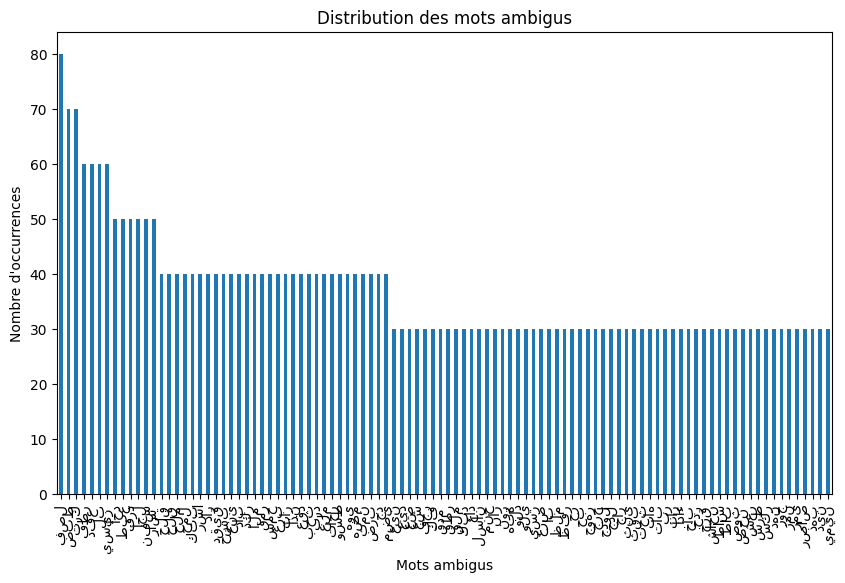

In [ ]:
import matplotlib.pyplot as plt

df['Word'].value_counts().plot(kind='bar', figsize=(10, 6), title='Distribution des mots ambigus')
plt.xlabel('Mots ambigus')
plt.ylabel('Nombre d\'occurrences')
plt.show()


In [ ]:
df['Word'].nunique()


100

In [ ]:
df.groupby('Word')['Meaning'].nunique()


,Meaning
Word,
أجل,5
أحد,5
أداء,3
أذن,4
اب,3
...,...
ولد,3
ولي,3
يسر,3


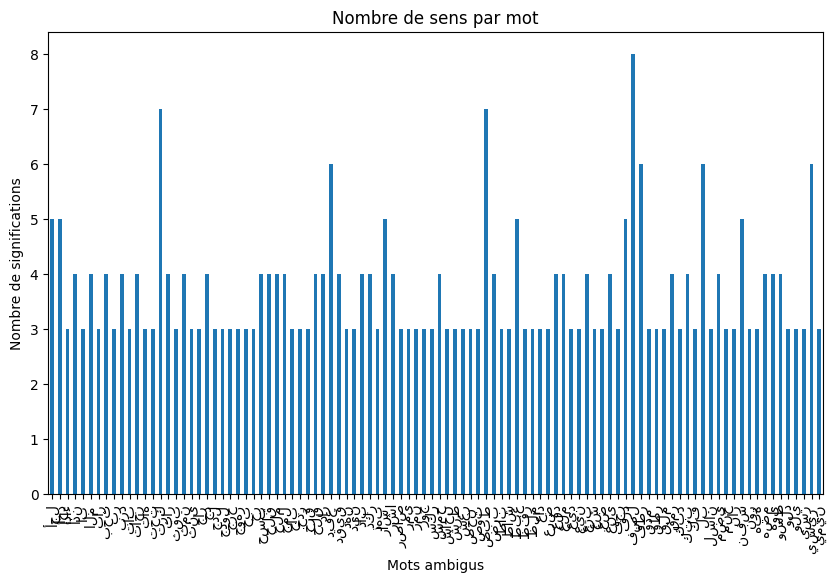

In [ ]:
df.groupby('Word')['Meaning'].nunique().plot(kind='bar', figsize=(10, 6), title='Nombre de sens par mot')
plt.xlabel('Mots ambigus')
plt.ylabel('Nombre de significations')
plt.show()


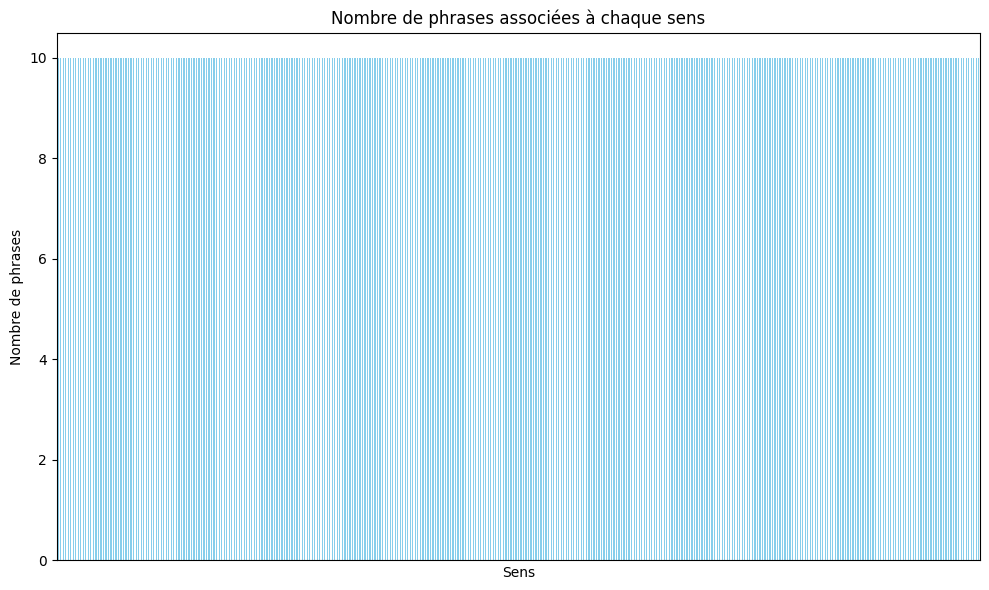

In [ ]:
import matplotlib.pyplot as plt

sentence_count_per_meaning = df.groupby('Meaning')['Sentence'].count()

# Visualiser la distribution avec un diagramme en barres
sentence_count_per_meaning.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Ajouter des titres et des labels
plt.title('Nombre de phrases associées à chaque sens')
plt.xlabel('Sens')
plt.ylabel('Nombre de phrases')
plt.xticks(rotation=45, ha='right')
plt.xticks([])

# Afficher le graphique
plt.tight_layout()
plt.show()


In [ ]:
df = df.drop(columns=['TargetID', 'Source'])


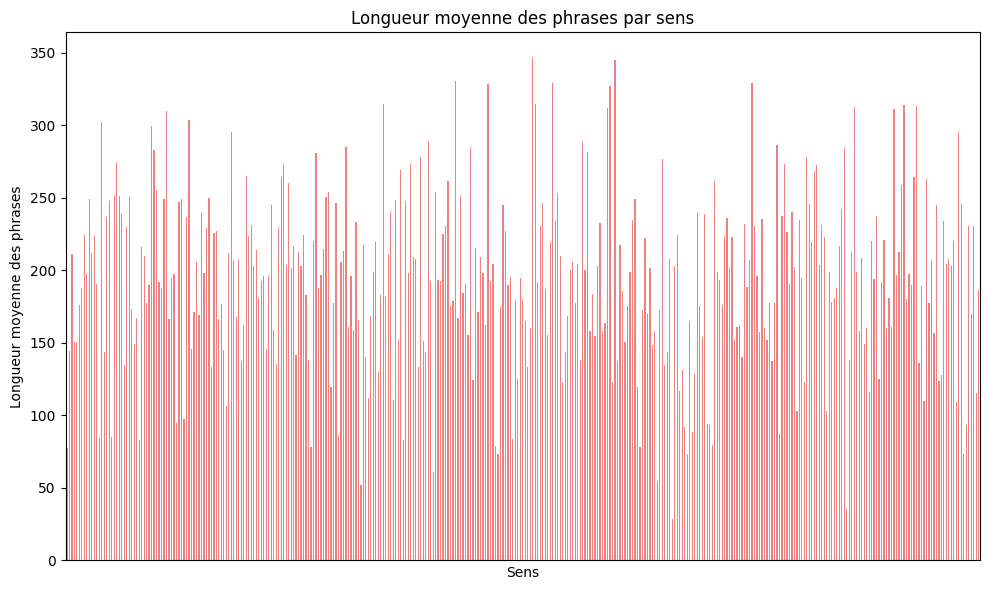

In [ ]:
# Ajouter une nouvelle colonne avec la longueur des phrases
df['sentence_length'] = df['Sentence'].apply(len)

# Calculer la longueur moyenne des phrases par sens
mean_length_per_meaning = df.groupby('Meaning')['sentence_length'].mean()

# Visualiser la longueur moyenne des phrases pour chaque sens
mean_length_per_meaning.plot(kind='bar', figsize=(10, 6), color='lightcoral')

# Ajouter des titres et des labels
plt.title('Longueur moyenne des phrases par sens')
plt.xlabel('Sens')
plt.ylabel('Longueur moyenne des phrases')
plt.xticks([])

# Afficher le graphique
plt.tight_layout()
plt.show()


Shape of embeddings: (3670, 768)


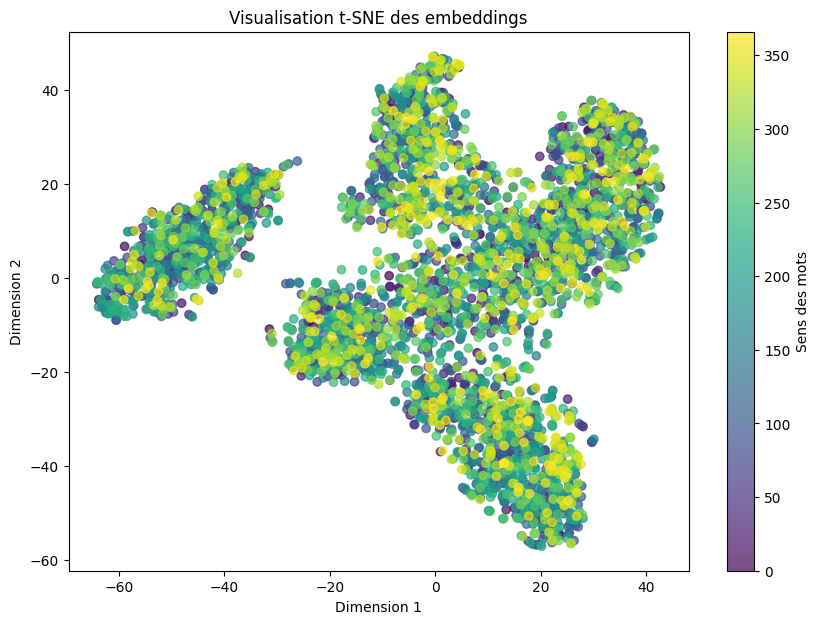

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Supposons que ta colonne 'embedding' dans le DataFrame df contient des listes de vecteurs
# 1. Convertir les embeddings en un tableau NumPy
embeddings_array = np.array(df['embedding'].tolist())

# 2. Vérifier la forme des embeddings
print("Shape of embeddings:", embeddings_array.shape)  # Doit être (n_samples, n_features)

# 3. Appliquer t-SNE pour réduire la dimensionnalité à 2D
if len(embeddings_array.shape) == 2:  # Assurez-vous qu'il y a bien deux dimensions
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings_array)

    # 4. Créer un DataFrame pour stocker les résultats t-SNE
    df_tsne = pd.DataFrame(embeddings_2d, columns=['Dim1', 'Dim2'])
    df_tsne['Meaning'] = df['Meaning']

    # 5. Visualiser les résultats t-SNE
    plt.figure(figsize=(10, 7))
    plt.scatter(df_tsne['Dim1'], df_tsne['Dim2'], c=df_tsne['Meaning'].factorize()[0], cmap='viridis', alpha=0.7)
    plt.title("Visualisation t-SNE des embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.colorbar(label='Sens des mots')
    plt.show()
else:
    print("Erreur : Les embeddings doivent avoir deux dimensions (n_samples, n_features)")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

# Convertir les embeddings en un tableau NumPy
embeddings_array = np.array(df['embedding'].tolist())

# Appliquer t-SNE pour réduire la dimensionnalité à 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Créer un DataFrame pour stocker les résultats t-SNE
df_tsne = pd.DataFrame(embeddings_2d, columns=['Dim1', 'Dim2'])
df_tsne['Meaning'] = df['Meaning']
df_tsne['Word'] = df['Word']

print(df_tsne.head())


        Dim1       Dim2      Meaning Word
0  10.692030 -34.161106  والد الشخص.   اب
1 -50.823532   6.907778  والد الشخص.   اب
2   8.444196   9.403230  والد الشخص.   اب
3  21.622007   9.794328  والد الشخص.   اب
4  27.481934   5.641830  والد الشخص.   اب


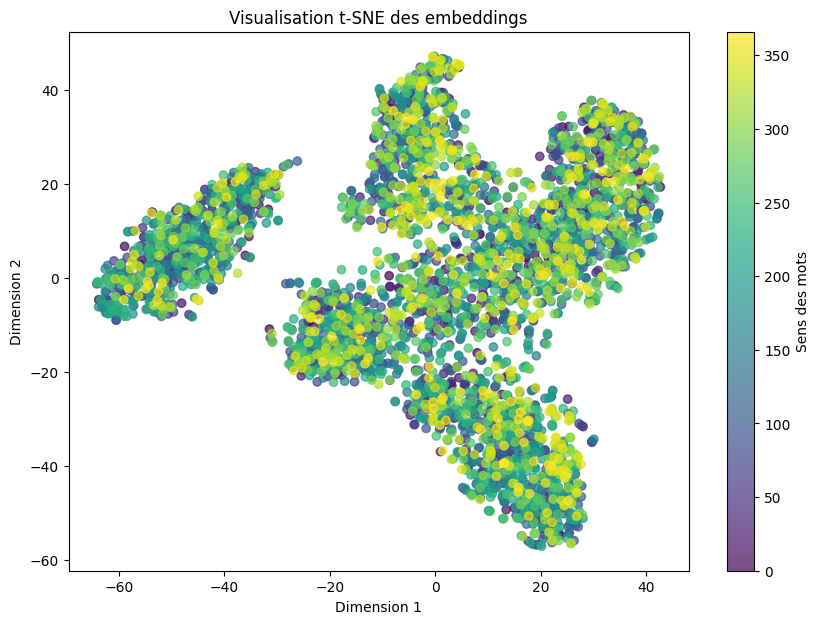

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_tsne['Dim1'], df_tsne['Dim2'], c=df_tsne['Meaning'].factorize()[0], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Sens des mots')
plt.title("Visualisation t-SNE des embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

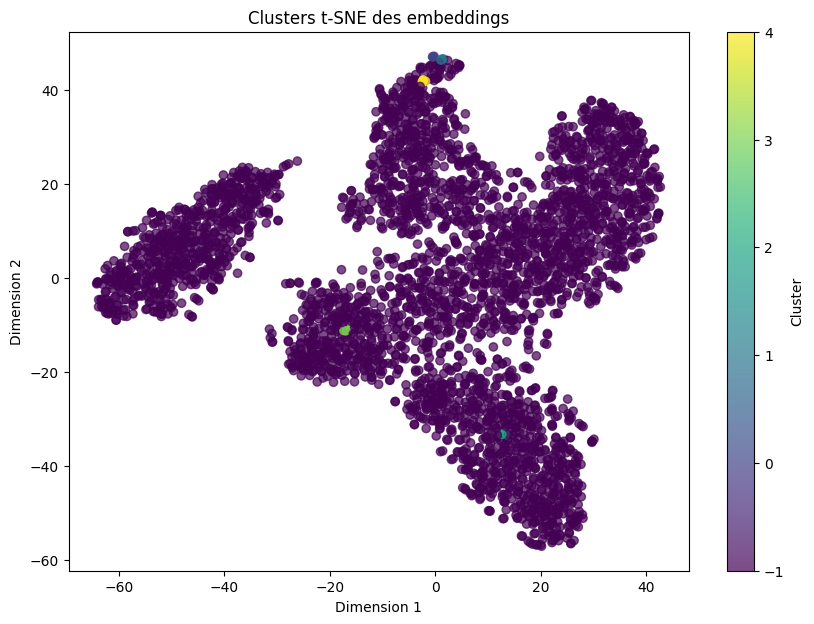

In [ ]:
from sklearn.cluster import DBSCAN

# Appliquer DBSCAN pour identifier les clusters
clustering = DBSCAN(eps=0.5, min_samples=5).fit(embeddings_2d)
df_tsne['Cluster'] = clustering.labels_

# Visualiser les clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_tsne['Dim1'], df_tsne['Dim2'], c=df_tsne['Cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title("Clusters t-SNE des embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


## Visualiser la distribution de la longueur des phrases en nombre de mots


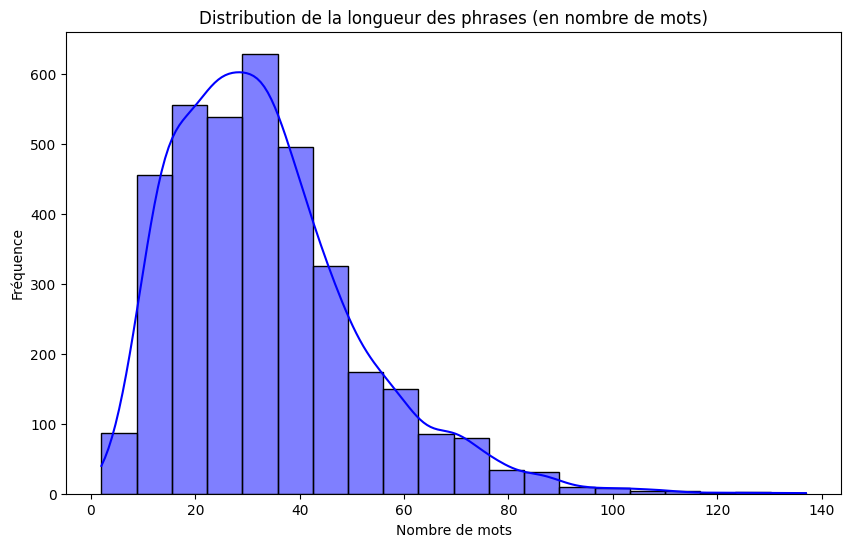

In [ ]:
df['sentence_length_words'] = df['Sentence'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['sentence_length_words'], bins=20, kde=True, color='blue')
plt.title('Distribution de la longueur des phrases (en nombre de mots)')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.show()

In [ ]:
# Calculer la longueur des phrases en nombre de mots (si ce n'est pas déjà fait)
df['sentence_length_words'] = df['Sentence'].apply(lambda x: len(x.split()))

# Compter la fréquence de chaque longueur de phrase
tableau_frequence = df['sentence_length_words'].value_counts().sort_index()

# Afficher le tableau de fréquences
tableau_frequence = tableau_frequence.reset_index()
tableau_frequence.columns = ['Nombre de mots', 'Fréquence']

print(tableau_frequence)


     Nombre de mots  Fréquence
0                 2          2
1                 3          9
2                 4          2
3                 5          7
4                 6         16
..              ...        ...
105             115          1
106             120          1
107             124          1
108             130          1
109             137          1

[110 rows x 2 columns]
